In [ ]:
#############################################################################
# 正射校正测试
# Copyright (C) 2024  Xu Ruijun
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
#############################################################################

In [1]:
import numpy as np
from osgeo import gdal, osr
from myraster import MyRaster
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
def read_points(path):
    with open(path, 'r') as f:
        res = []
        crs = f.readline()
        assert crs[:6] == '#CRS: '
        osra = osr.SpatialReference(crs[6:])
        assert f.readline() == 'mapX,mapY,sourceX,sourceY,enable,dX,dY,residual\n'
        while True:
            line = f.readline()
            if len(line) == 0:
                break
            res.append(tuple(map(float, line.split(','))))
    return osra, res

In [3]:
# DEM是从USGS EarthExplorer下载的多张30m SRTM, 并用gdal合并的虚拟图层
dem=MyRaster(gdal.Open('/mnt/2thdd-btrfs/rs/DEM/SRTM1_v3/USGS_EE/virtal.vrt'))
# 地面控制点文件是用QGIS的Georeferencer工具制作
# USGS解密影像与现代资料（OpenStreetMap，Sentinel-2和一些自己的GPX文件等）对比，选取了一些长期不变的点
#path_points = '/mnt/2thdd-btrfs/rs/USGS_Declass/DS1015-1021DF073/DS1015-1021DF073_c.tif.points'
path_points = '/mnt/2thdd-btrfs/rs/USGS_Declass/D3C1215-401419A011/D3C1215-401419A011_e.tif.points'

In [4]:
osra, res = read_points(path_points)
osrgeo = osr.SpatialReference()
osrgeo.SetWellKnownGeogCS("WGS84")
ct_geo2prj = osr.CoordinateTransformation(osrgeo, osra)
ct_prj2geo = osr.CoordinateTransformation(osra, osrgeo)
data = []
for mapX,mapY,sourceX,sourceY,enable,dX,dY,residual in res:
    lat, lon = ct_prj2geo.TransformPoint(mapX, mapY)[:2]
    h = dem.get_geopoint_cubic(lon, lat)
    data.append((lat, lon, h, sourceX, sourceY))
    print(f'{lat:.5f}, {lon:.5f}, {h:.0f}, {sourceX:.0f}, {sourceY:.0f}')
data = np.array(data)
print(data.mean(axis=0))
print(len(data))

30.08455, 120.56050, 5, 16433, -17237
30.08066, 120.55324, 6, 17228, -16622
29.99803, 120.56361, 8, 14563, -5574
30.05613, 120.45384, 9, 28652, -12034
30.05347, 120.45612, 8, 28340, -11704
30.03196, 120.45630, 15, 27982, -8784
30.00135, 120.53514, 6, 18020, -5647
30.07184, 120.41992, 8, 32957, -13729
30.12122, 120.60107, 7, 12294, -22628
30.09488, 120.43264, 10, 31790, -17001
30.05497, 120.66658, 6, 3449, -14616
30.10485, 120.39856, 7, 36010, -17904
29.98058, 120.65131, 6, 3855, -4364
30.00076, 120.43992, 38, 29444, -4307
30.04988, 120.46144, 8, 27644, -11285
30.12739, 120.40110, 12, 36037, -20964
30.10306, 120.50965, 5, 22764, -19073
30.07040, 120.47227, 12, 26686, -14204
30.02731, 120.53981, 4, 17908, -9235
29.99726, 120.42892, 49, 30722, -3682
30.01593, 120.42640, 51, 31305, -6205
29.98720, 120.41517, 128, 32218, -2124
29.98738, 120.42289, 193, 31290, -2270
29.98808, 120.38073, 151, 36405, -1800
30.03474, 120.45713, 10, 27918, -9164
30.02654, 120.43360, 11, 30614, -7748
30.02660, 12

In [246]:
pl=(data[:,:2]-(30.05, 120.5))
plh=np.concatenate([pl, data[:,2:3]], axis=1)
#plh=pl
xy = data[:,-2:]

In [247]:
pfX = PolynomialFeatures(degree=3)
pfX.fit(pl)
def mytransf(x):
    #x = pfX.transform(x)
    # remove z^3
    #return np.concatenate([x[:, :19]], axis=-1)
    # remove z^2, xz^2, yz^2, z^3
    #return np.concatenate([x[:, :9], x[:, 10:15], x[:, 16:18]], axis=-1)
    # remove z^2, x^2z, y^2z, xz^2, yz^2, xyz, z^3
    #return np.concatenate([x[:, :9], x[:, 10:12], x[:, 13:14], x[:, 16:17]], axis=-1)
    xpl = pfX.transform(x[:,:2])
    return np.concatenate([xpl, x[:,2:3]], axis=-1)
X = mytransf(plh)
model=linear_model.LinearRegression()
model.fit(X, xy)
print(model.coef_)

[[ 0.00000000e+00  1.65570159e+04 -1.19354123e+05 -1.81760158e+03
   1.35945588e+04  5.17128457e+03 -3.08640316e+03 -1.87303646e+03
  -1.26359432e+04  1.18564360e+04 -2.68082490e-02]
 [ 0.00000000e+00 -1.35503229e+05 -1.30097399e+04  1.47300284e+04
   6.60923803e+03  3.94938322e+01  1.05064602e+04  1.09189307e+04
   1.26825453e+04  4.49654544e+03 -1.32634780e-01]]


In [248]:
err=model.predict(mytransf(plh))-xy
errx=err[:,0]
erry=err[:,1]
erra=np.sqrt(errx**2+erry**2)
rms=np.sqrt(np.sum(err**2)/(np.size(err)-np.size(model.coef_)))
print(erra)
print(np.max(erra), rms)

[1.58675689 1.85915527 3.01901287 1.61363511 1.87755909 7.98008725
 2.51729369 3.16338206 5.2953873  2.69439071 3.68775675 5.52887314
 2.13969136 3.77608942 0.94765847 0.63566668 2.58847367 6.48129373
 9.01092092 3.85291144 9.70656705 5.26233175 7.87100413 1.27111921
 6.9165604  1.92352466 3.15258421 6.18156146 0.85662591 0.21124665
 6.04541544 6.98728056 2.99950974 3.37017933 1.60181305 1.4751076
 3.14250124 6.6877216  3.71466735 3.09275338 1.55372744 5.04015909
 2.66155811 2.86993487 4.41458552 1.7573647  2.7071351  2.74472254
 7.95713121 9.10987167 4.4719062  3.52490432 7.62245475 4.47875505
 5.54096932 5.11457583 1.6663186  4.28594511 5.43085665 2.32467625
 3.50920426 6.29846569 8.24148642 3.97182736 2.94223422 6.09498456
 3.1626378 ]
9.706567047510687 3.612774126154679


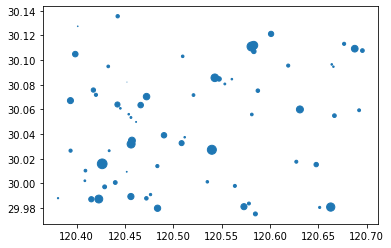

In [252]:
plt.scatter(data[:,1], data[:,0], s=erra**2)
#plt.scatter(data[:,1], data[:,0], s=data[:,2])
plt.show()

In [253]:
np.matmul(model.coef_, mytransf(np.array([(0.0,0.01,0)]))[0]) + model.intercept_

array([ 21844.45218279, -11932.64211481])

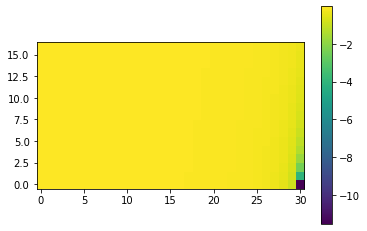

In [257]:
lat=(np.arange(29.96, 30.13, 0.01)-30.05)
lon=(np.arange(120.38, 120.69, 0.01)-120.5)
L, B = np.meshgrid(lon, lat)
BL0 = np.array([B, L, np.zeros_like(B)]).transpose((1,2,0)).reshape((-1,3))
BL1 = np.array([B, L, np.ones_like(B)]).transpose((1,2,0)).reshape((-1,3))
a = model.predict(mytransf(BL0)).reshape((len(lat), len(lon), 2))
b = model.predict(mytransf(BL1)).reshape((len(lat), len(lon), 2))
plt.imshow(np.diff(a[:,:,0], axis=1)/a[:,:-1,0], origin='lower')
plt.colorbar()
plt.show()

In [296]:
def parttofull(x):
    i, p, l, p2, lp, l2, p3, p2l, l2p, l3, h = x.transpose()
    lh = ph = h2 = plh = h2l = h2p = l2h = p2h = h3 = np.zeros_like(i)
    return np.array([i, l, p, h, lp, lh, ph, l2, p2, h2, plh, l3, p2l, h2l, l2p, p3, h2p, l2h, p2h, h3])

def write_rpc(fn, model):
    with open(fn, 'w') as f:
        f.write('ERR_BIAS: 0.0\n'
                'ERR_RAND: 0.0\n'
                f'LINE_OFF: {-model.intercept_[1]}\n'
                f'SAMP_OFF: {model.intercept_[0]}\n'
                'LAT_OFF: 30.05\n'
                'LONG_OFF: 120.5\n'
                'HEIGHT_OFF: 1\n'
                'LINE_SCALE: 1\n'
                'SAMP_SCALE: 1\n'
                'LAT_SCALE: 1\n'
                'LONG_SCALE: 1\n'
                'HEIGHT_SCALE: 1\n')
        line_num_coeff = -parttofull(model.coef_[1])
        line_den_coeff = np.zeros(20)
        line_den_coeff[0] = 1
        samp_num_coeff = parttofull(model.coef_[0])
        samp_den_coeff = np.zeros(20)
        samp_den_coeff[0] = 1
        for i in range(20):
            f.write(f'LINE_NUM_COEFF_{i+1}: {line_num_coeff[i]}\n')
        for i in range(20):
            f.write(f'LINE_DEN_COEFF_{i+1}: {line_den_coeff[i]}\n')
        for i in range(20):
            f.write(f'SAMP_NUM_COEFF_{i+1}: {samp_num_coeff[i]}\n')
        for i in range(20):
            f.write(f'SAMP_DEN_COEFF_{i+1}: {samp_den_coeff[i]}\n')
write_rpc('/mnt/2thdd-btrfs/rs/USGS_Declass/D3C1215-401419A011/D3C1215-401419A011_e_RPC.TXT', model)